# &#x1F4D1; &nbsp; $\mathfrak {\color{#228B22} { Keras \ Cookbook}}$
## 0. Code Library and Links

In [1]:
import numpy as np 
import pandas as pd
import os
import json

import scipy
import cv2
import seaborn
import time

from PIL import ImageFile
from tqdm import tqdm
from skimage import io

import matplotlib.pylab as plt
from matplotlib import cm

%matplotlib inline

In [2]:
import keras

Using TensorFlow backend.


In [3]:
import tensorflow.examples.tutorials.mnist as mnist

In [4]:
from keras.datasets import cifar10, imdb, boston_housing

In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files  

In [7]:
from keras.preprocessing import sequence
from keras.preprocessing import image as keras_image

In [8]:
from keras.utils import to_categorical, np_utils

In [9]:
from keras.models import Sequential, Model
from keras.models import load_model, model_from_json

In [10]:
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling2D
from keras.layers.embeddings import Embedding

In [11]:
from keras.layers import Dense, LSTM
from keras.layers import Activation, Flatten, Dropout
from keras.layers import Input, BatchNormalization

In [21]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input

In [103]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess_input

In [15]:
from keras.layers.advanced_activations import PReLU

In [81]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [92]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [83]:
def loss_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['loss'], label = 'train')
    plt.plot(fit_history.history['val_loss'], label = 'test')

    plt.legend()
    plt.title('Loss Function');  
    
def mae_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['mean_absolute_error'], label = 'train')
    plt.plot(fit_history.history['val_mean_absolute_error'], label = 'test')

    plt.legend()
    plt.title('Mean Absolute Error'); 

def acc_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['acc'], label = 'train')
    plt.plot(fit_history.history['val_acc'], label = 'test')

    plt.legend()
    plt.title('Accuracy');     

In [64]:
def decode_predictions2(preds, fpath, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        results.append(result)
    return results

## 1. Backend

In [15]:
'''
/.keras/keras.json
{"image_data_format": "channels_last",
 "epsilon": 1e-07,
 "floatx": "float32",
 "backend": "tensorflow"}
'''
''''''

''

In [16]:
# variants: "theano", "tensorflow", "cntk"
keras.backend.backend()

'tensorflow'

In [17]:
keras.backend.image_dim_ordering()

'tf'

## 2. Data Samples

In [23]:
# 32x32 color images; 50,000 - the train set; 10,000 - the test set; labeled over 10 categories
(x_train1, y_train1), (x_test1, y_test1) = cifar10.load_data()

In [24]:
(x_train1.shape, y_train1.shape), (x_test1.shape, y_test1.shape)

(((50000, 32, 32, 3), (50000, 1)), ((10000, 32, 32, 3), (10000, 1)))

Label:  9


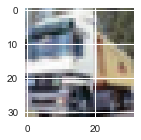

In [25]:
print('Label: ', y_train1[1][0])
plt.figure(figsize=(2,2))
plt.imshow(x_train1[1]);

In [26]:
# 28x28 grayscale images; 55,000 - the train set; 10,000 - the test set; labeled over 10 categories
mnist_data = mnist.input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [27]:
(x_train2, y_train2), (x_test2, y_test2) = \
(mnist_data.train.images, mnist_data.train.labels), (mnist_data.test.images, mnist_data.test.labels)

In [28]:
(x_train2.shape, y_train2.shape), (x_test2.shape, y_test2.shape)

(((55000, 784), (55000, 10)), ((10000, 784), (10000, 10)))

In [29]:
y_test2_class = []

for i in range(10000):
    y_test2_class.append(np.argmax(y_test2[i]))
    
y_test2_class = np.array(y_test2_class)

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


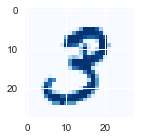

In [30]:
print(y_train2[1])
plt.figure(figsize=(2,2))
plt.imshow(x_train2[1].reshape(28,28), cmap=cm.Blues);

In [31]:
# 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative)
num_words, max_length, embedding_vector_length = 10000, 1000, 32
(x_train3, y_train3), (x_test3, y_test3) = imdb.load_data(path="imdb_full.pkl", num_words=num_words,
                                                          skip_top=0, maxlen=max_length, seed=113,
                                                          start_char=1, oov_char=2, index_from=3)

In [32]:
(x_train3.shape, y_train3.shape), (x_test3.shape, y_test3.shape)

(((25000,), (25000,)), ((24819,), (24819,)))

In [33]:
# 13 attributes of houses at different locations, targets are the median values of the houses at a location (in k$)
(x_train4, y_train4), (x_test4, y_test4) =  boston_housing.load_data()

In [34]:
(x_train4.shape, y_train4.shape), (x_test4.shape, y_test4.shape)

(((404, 13), (404,)), ((102, 13), (102,)))

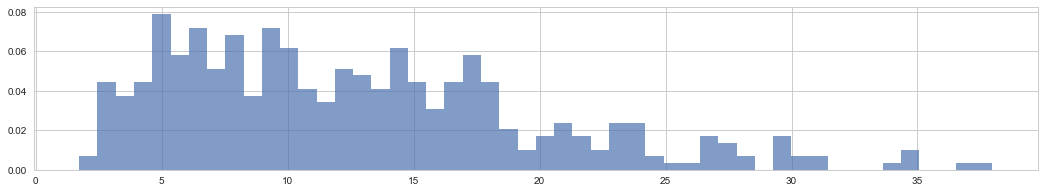

In [35]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(18, 3))
plt.hist(y_train4, bins=50, normed=True, alpha=0.7);

In [36]:
# Classification; the artificial set, labeled over 2 categories 
X5, Y5 = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2)
x_train5, x_test5, y_train5, y_test5 = train_test_split(X5, Y5, test_size = 0.2, random_state = 1)

In [37]:
(x_train5.shape, y_train5.shape), (x_test5.shape, y_test5.shape)

(((800, 2), (800,)), ((200, 2), (200,)))

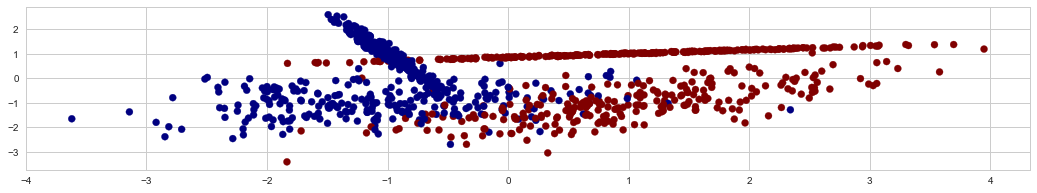

In [38]:
plt.figure(figsize=(18, 3))
plt.scatter(X5[:, 0], X5[:, 1], marker='o', c=Y5, cmap=cm.jet);

In [39]:
# 150x150 grayscale face images; 149 - the train set; 17 - the test set; labeled over 15 categories(persons)
yalefaces_paths = []
yalefaces_images = []
yalefaces_labels = []

for element in os.listdir("yalefaces"):
    if element != 'Readme.txt':
        yalefaces_paths.append(os.path.join("yalefaces", element))
    
for path in yalefaces_paths:
    image = io.imread(path, as_grey=True)
    yalefaces_images.append(image)
    
    label = int(os.path.split(path)[1].split(".")[0].replace("subject", "")) - 1
    yalefaces_labels.append(label) 
    
yalefaces_cut_images = []
face_detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
for i in range(len(yalefaces_images)):
    image = yalefaces_images[i]
    face = face_detector.detectMultiScale(image)
    x, y = face[0][:2]
    cut_image = image[y: y+150, x: x+150]
    yalefaces_cut_images.append(cut_image)    

Label:  0


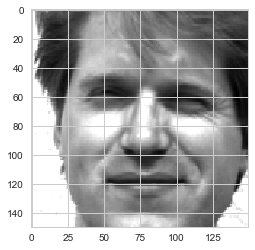

In [40]:
yalefaces_labels = np.array(yalefaces_labels)
yalefaces_cut_images = np.array(yalefaces_cut_images)

print('Label: ', yalefaces_labels[11])
plt.imshow(yalefaces_cut_images[11], cmap='gray');

In [41]:
x_train6, x_test6, y_train6, y_test6 = train_test_split(yalefaces_cut_images, yalefaces_labels, 
                                                        test_size = 0.1, random_state = 1)
[x_train6.shape, y_train6.shape, x_test6.shape, y_test6.shape]

[(149, 150, 150), (149,), (17, 150, 150), (17,)]

In [42]:
# 128x128 flower color images; 189 - the train set; 21 - the test set; labeled over 10 categories
flowers = pd.read_csv("flower_images/flower_labels.csv")
flower_files = flowers['file']
flower_targets = flowers['label'].as_matrix()

In [43]:
def path_to_tensor(img_path):
    img = keras_image.load_img("flower_images/"+img_path, target_size=(128, 128))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True                 

flower_tensors = paths_to_tensor(flower_files);

100%|██████████| 210/210 [00:15<00:00, 13.61it/s]


Label:  0


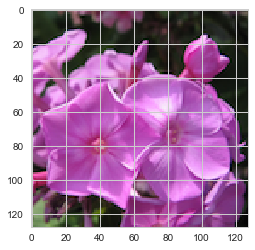

In [44]:
print('Label: ', flower_targets[1])
flower_image = cv2.imread('flower_images/'+flower_files[1])
rgb_flower_image = cv2.cvtColor(flower_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_flower_image);

In [45]:
x_train7, x_test7, y_train7, y_test7 = train_test_split(flower_tensors, flower_targets, 
                                                        test_size = 0.1, random_state = 1)
[x_train7.shape, y_train7.shape, x_test7.shape, y_test7.shape]

[(189, 128, 128, 3), (189,), (21, 128, 128, 3), (21,)]

## 3. Preprocessing

In [46]:
# Sequence Padding
p_x_train3 = sequence.pad_sequences(x_train3, maxlen=max_length)
p_x_test3 = sequence.pad_sequences(x_test3, maxlen=max_length)

In [47]:
# Normalizing and Reshaping
x_train1 = x_train1/255
x_test1 = x_test1/255

x_train6 = (x_train6).reshape(149, 150*150)
x_test6 = (x_test6).reshape(17, 150*150)
x_train6 = x_train6.astype('float32')/255
x_test6 = x_test6.astype('float32')/255

r_x_train6 = x_train6.reshape(149, 150, 150, 1)
r_x_test6 = x_test6.reshape(17, 150, 150, 1)

In [48]:
x_train7 = x_train7.astype('float32')/255
x_test7 = x_test7.astype('float32')/255

In [49]:
# One-Hot Encoding
c_y_train1 = to_categorical(y_train1, 10)
c_y_test1 = to_categorical(y_test1, 10)

c_y_train5 = to_categorical(y_train5, 10)
c_y_test5 = to_categorical(y_test5, 10)

c_y_train6 = to_categorical(y_train6, 15)
c_y_test6 = to_categorical(y_test6, 15)

In [50]:
c_y_train7 = to_categorical(y_train7, 10)
c_y_test7 = to_categorical(y_test7, 10)

In [51]:
[x_train5.shape, c_y_train5.shape, x_test5.shape, c_y_test5.shape]

[(800, 2), (800, 10), (200, 2), (200, 10)]

In [52]:
[r_x_train6.shape, c_y_train6.shape, r_x_test6.shape, c_y_test6.shape]

[(149, 150, 150, 1), (149, 15), (17, 150, 150, 1), (17, 15)]

In [53]:
[x_train7.shape, c_y_train7.shape, x_test7.shape, c_y_test7.shape]

[(189, 128, 128, 3), (189, 10), (21, 128, 128, 3), (21, 10)]

## 4. Models

*Optimizers:*

- 'adam', 'nadam', 
- 'adagrad', 'adadelta', 'adamax',
- 'sgd', 'rmsprop',
- TFOptimizer.

*Loss functions:*

- 'mean_squared_error'('mse'), 'mean_absolute_error'('mae'), 
- 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error',
- 'squared_hinge', 'hinge', 'categorical_hinge',
- 'categorical_crossentropy', 'sparse_categorical_crossentropy',
- 'binary_crossentropy',
- 'kullback_leibler_divergence',
- 'poisson',
- 'cosine_proximity',
- 'logcosh'.

*Metrics:*

- mae, mse, acc,
- binary_accuracy, 
- categorical_accuracy, sparse_categorical_accuracy,
- top_k_categorical_accuracy, sparse_top_k_categorical_accuracy.

----

##### Compilation

*For a multi-class classification problem:*

- model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
- model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

*For a binary classification problem:*

- model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
- model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

*For a mean squared error regression problem:*

- model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
- model.compile(optimizer='sgd', loss='mse', metrics=['mae'])
----

##### Activation
- http://cs231n.github.io/neural-networks-1/

*Types:*

- 'elu', 'selu', 'relu', 'tanh', 'linear', 'softmax', 'softplus', 'softsign', 'sigmoid', 'hard_sigmoid'
- LeakyReLU, PReLU, ELU, ThresholdedReLU

*For a multi-class classification problem:*

- 'softmax'

*For a binary classification problem:*

- 'sigmoid'

*For a mean squared error regression problem:*

- 'linear'

##### Layers

1. *Core Layers*
  - https://keras.io/layers/core/   
  - `Input` layers hold an input tensor (for example, the pixel values of the image with width 32, height 32, and 3 color channels).
  - `Dense` (fully connected) layers compute the class scores, resulting in volume of size. For example, the size [11] corresponds to class scores, such as 10 digits and 1 empty place. Each neuron in these layers are connected to all the numbers in the previous volume.
  - `Activation` applies an activation function to an output. This leaves the size of the volume unchanged.
  - `Dropout` layers consist in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. This leaves the size of the volume unchanged.
  - `Reshape` layers convert an output to a certain shape.
  - `Flatten` layers flatten the input and collapses it into the one-dimensional feature vector. This results in the volume such as [2, 30, 64] -> [3840].
  - etc.

2. *Convolutional Layers* 
  - http://cs231n.stanford.edu/slides/2016/winter1516_lecture7.pdf
  - https://www.inf.ed.ac.uk/teaching/courses/nlu/lectures/nlu_l15_convolution-2x2.pdf   
  - `Conv1D` layers (temporal convolution) convolve the filter with the signal, i.e. “is sliding over the signal vector, computing dot products”. Here the filter is an integer, the dimensionality of the output space (i.e. the number output of filters in the convolution) and the kernel size is an integer, specifying the length of the 1D convolution window.
  - `Conv2D` layers (spatial convolution over images) compute the output of neurons that are connected to local regions in the input each computing a dot product between their weights and a small region they are connected to in the input volume. This results in the volume such as [64, 64, 1] -> [64, 64, 32] when it was used 32 filters.
  - `Conv3D` layers (spatial convolution over volumes).
  - `SeparableConv2D`, `Conv2DTranspose`.
  - etc.
  
3. *Recurrent Layers*
  - `SimpleRNN` layers are fully-connected RNN. This leaves the size of the volume unchanged.
  - `LSTM` layers.
  - `GRU` layers.
  
4. *Pooling Layers*
  - http://cs231n.github.io/convolutional-networks/ 
  - `MaxPooling2D` layers perform a downsampling operation along the spatial dimensions (width, height). Max-pooling partitions the input image into a set of non-overlapping rectangles and, for each such subregion, outputs the maximum value. This results in the volume such as [28, 28, 32] -> [14, 14, 32].
  - `MaxPooling1D` & `MaxPooling3D` is a max pooling operation for temporal (1D) data and spatial or spatio-temporal (3D) data  respectively.
  
5. *Advanced Activations Layers*
  - `LeakyReLU`.
    - f(x) = alpha * x for x < 0, f(x) = x for x >= 0, alpha is a small gradient.
  - `PReLU`.
    - f(x) = alpha * x for x < 0, f(x) = x for x >= 0, alpha is a learned array.
  - `ELU`.
    - f(x) =  alpha * (exp(x) - 1.) for x < 0, f(x) = x for x >= 0, alpha is a small gradient.
  - `ThresholdedReLU`.
    - f(x) = x for x > theta, f(x) = 0 otherwise.
    
etc.

In [37]:
# The basic example (binary classification)
basic_model = Sequential([Dense(16, input_dim=2), Activation('relu'), Dense(1), Activation('sigmoid')])
basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
# Train the model
basic_model.fit(x_train5, y_train5, epochs=100, batch_size=8, verbose=0)
# Predict classes
y_train5_predictions = basic_model.predict_classes(x_train5)

 32/800 [>.............................] - ETA: 0s

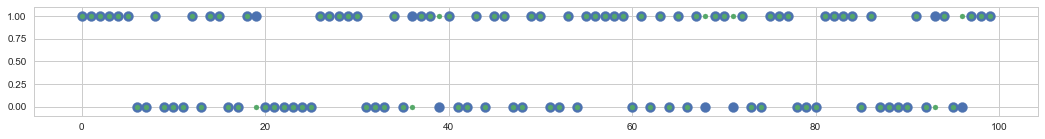

In [39]:
plt.figure(figsize=(18,2))
plt.scatter(range(100), y_train5[:100], s=100)
plt.scatter(range(100), y_train5_predictions[:100], s=25)

In [40]:
# Model performance
basic_score = basic_model.evaluate(x_test5, y_test5, batch_size=200)
basic_score

200/200 [==============================] - 0s


[0.24363216757774353, 0.91500002145767212]

In [41]:
basic_model.input

<tf.Tensor 'dense_1_input:0' shape=(?, 2) dtype=float32>

In [42]:
# Model parameters
basic_model.output_shape

(None, 1)

In [43]:
basic_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [44]:
basic_model.get_config()

[{'class_name': 'Dense',
  'config': {'activation': 'linear',
   'activity_regularizer': None,
   'batch_input_shape': (None, 2),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dtype': 'float32',
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'dense_1',
   'trainable': True,
   'units': 16,
   'use_bias': True}},
 {'class_name': 'Activation',
  'config': {'activation': 'relu', 'name': 'activation_1', 'trainable': True}},
 {'class_name': 'Dense',
  'config': {'activation': 'linear',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'c

In [45]:
basic_model.get_weights() 

[array([[  1.14988692e-01,   7.39514053e-01,   8.99778664e-01,
          -4.06576514e-01,   2.93621570e-01,  -6.02392435e-01,
          -9.99462545e-01,   2.70990759e-01,   1.05869889e-01,
          -1.16196406e+00,   7.74778798e-02,   1.34293437e+00,
          -1.03691804e+00,   3.14029157e-01,   2.80083388e-01,
           2.78159708e-01],
        [  1.32857412e-02,   2.70391583e-01,  -2.03058034e-01,
          -7.16618523e-02,  -8.58458161e-01,  -1.85937762e-01,
          -1.45854861e-01,  -7.88422167e-01,  -6.95703566e-01,
          -1.34819821e-01,  -2.60435455e-02,   8.38139653e-01,
          -7.51864514e-04,  -7.27212131e-01,  -8.61169279e-01,
          -5.83565712e-01]], dtype=float32),
 array([-0.31003243,  0.46879435,  0.25011161,  0.0873045 , -0.55469447,
        -0.41464594,  0.12148448, -0.50958979,  0.58887398,  0.17304073,
        -0.23444313,  0.43757468,  0.1355066 , -0.45536536, -0.55971968,
        -0.3492035 ], dtype=float32),
 array([[-0.07733599],
        [ 1.13134

In [46]:
# Optimization
opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-5)
opt2 = keras.optimizers.SGD(lr=0.001, decay=1e-5, momentum=0.9, nesterov=True)

basic_model2 = Sequential([Dense(16, input_dim=2), Activation('relu'), Dense(1), Activation('sigmoid')])
basic_model2.compile(optimizer=opt2, loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
basic_model2.fit(x_train5, y_train5, batch_size=8, epochs=100, verbose=0) 

basic_score2 = basic_model2.evaluate(x_test5, y_test5, batch_size=200)
basic_score2

200/200 [==============================] - 0s


[0.26740512251853943, 0.90499997138977051]

In [86]:
# Advanced activation

# encoder
inp = Input(shape=(2,))
act = PReLU(alpha_initializer='zeros')
lay = Dense(16, kernel_initializer='uniform', name='encoder')(inp)
lay = act(lay)

# decoder
out = Dense(1, kernel_initializer='uniform', activation='sigmoid', name='decoder')(lay)

# model
basic_model3 = Model(inputs=inp, outputs=out, name='cae')
basic_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [87]:
basic_model3.fit(x_train5, y_train5, epochs=100, batch_size=8, verbose=0)
basic_model3.evaluate(x_test5, y_test5, batch_size=200)

200/200 [==============================] - 2s


[0.25063899159431458, 0.9100000262260437]

In [58]:
# Save/reload models
basic_model.save('basic_model_file.h5')
my_basic_model = load_model('basic_model_file.h5')

In [88]:
# Interrupt training when the validation loss isn’t decreasing
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
basic_model3.fit(x_train5, y_train5, validation_data=(x_test5, y_test5),
                 epochs=200, batch_size=8, verbose=0, callbacks=[early_stopping])
basic_model3.evaluate(x_test5, y_test5, batch_size=200)

200/200 [==============================] - 0s


[0.23811648786067963, 0.9100000262260437]

## 5. Neural Networks
### 5.1 Multi-layer Perceptron

In [422]:
# MLP: Binary Classification
def mlp_bc_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=2, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(16, kernel_initializer='uniform', activation='relu'))
    
    model.add(Dropout(0.25))
    
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [423]:
mlp_bc_model = mlp_bc_model()
mlp_bc_model.fit(x_train5, y_train5, epochs=100, batch_size=8, verbose=0)
y_train5_mlp_predictions = mlp_bc_model.predict_classes(x_train5)
y_test5_mlp_predictions = mlp_bc_model.predict_classes(x_test5)

 32/200 [===>..........................] - ETA: 0s 

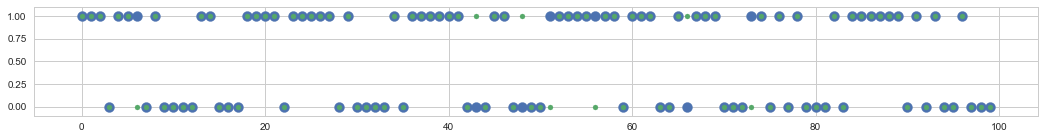

In [424]:
plt.figure(figsize=(18,2))
plt.scatter(range(100), y_test5[:100], s=100)
plt.scatter(range(100), y_test5_mlp_predictions[:100], s=25);

In [425]:
mlp_bc_test_score = mlp_bc_model.evaluate(x_test5, y_test5, batch_size=200)
mlp_bc_test_score

200/200 [==============================] - 2s


[0.25528141856193542, 0.91500002145767212]

In [31]:
# MLP: Multi-Class Classification
def mlp_mc_model():
    model = Sequential()
    
    model.add(Dense(196, activation='relu', input_shape=(784,)))
    model.add(Dropout(0.2))
    
    model.add(Dense(784, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [32]:
mlp_mc_model = mlp_mc_model()
mlp_mc_model.fit(x_train2, y_train2, epochs=10, batch_size=8, verbose=0)
y_train2_mlp_predictions = mlp_mc_model.predict_classes(x_train2)
y_test2_mlp_predictions = mlp_mc_model.predict_classes(x_test2)

10000/10000 [==============================] - 1s      

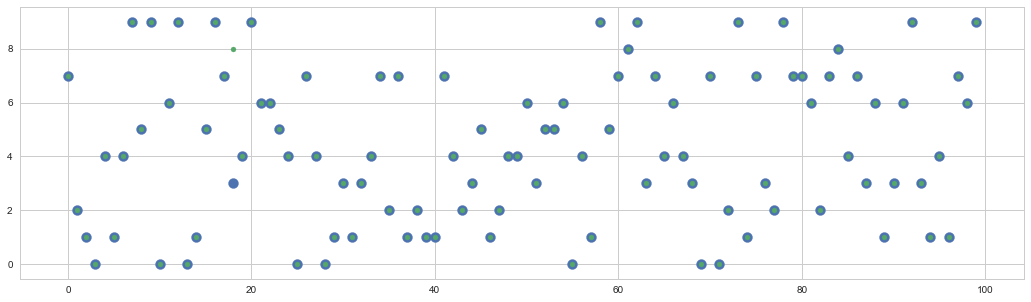

In [132]:
plt.figure(figsize=(18,5))
plt.scatter(range(100), y_test2_class[:100], s=100)
plt.scatter(range(100), y_test2_mlp_predictions[:100], s=25);

In [54]:
mlp_mc_test_score = mlp_mc_model.evaluate(x_test2, y_test2)
mlp_mc_test_score

 9664/10000 [===========================>..] - ETA: 0s  

[0.10468304518835775, 0.97789999999999999]

In [68]:
# MLP: Multi-Class Classification
def mlp_mc_model2():
    model = Sequential()
    
    model.add(Dense(512, activation='relu', input_shape=(22500,)))
    model.add(Dropout(0.15))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.15))
    
    model.add(Dense(15, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [69]:
mlp_mc_model2 = mlp_mc_model2()
mlp_mc_history2 = mlp_mc_model2.fit(x_train6, c_y_train6,
                                    validation_data=(x_test6, c_y_test6),
                                    epochs=70, batch_size=64, verbose=0)
y_train6_mlp_predictions = mlp_mc_model2.predict_classes(x_train6)
y_test6_mlp_predictions = mlp_mc_model2.predict_classes(x_test6)

17/17 [==============================] - 0s


In [70]:
mlp_mc_test_score2 = mlp_mc_model2.evaluate(x_test6, c_y_test6)
mlp_mc_test_score2

17/17 [==============================] - 0s


[0.11638676375150681, 1.0]

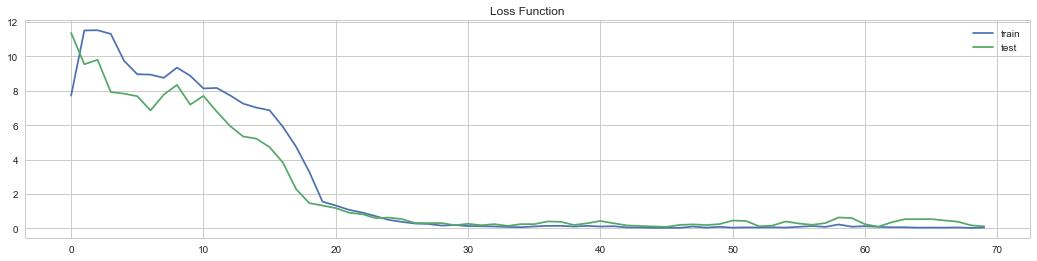

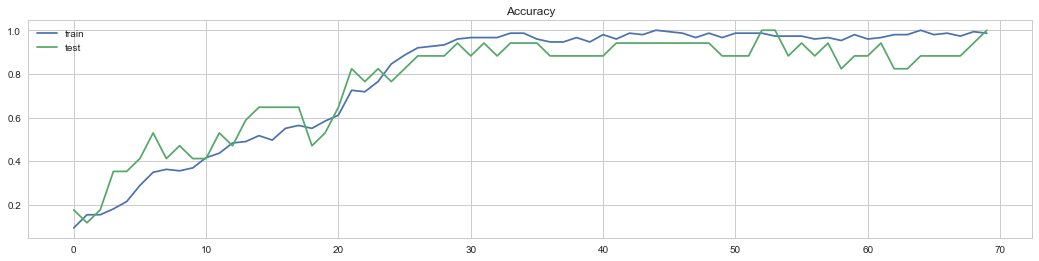

In [71]:
loss_plot(mlp_mc_history2)
acc_plot(mlp_mc_history2)

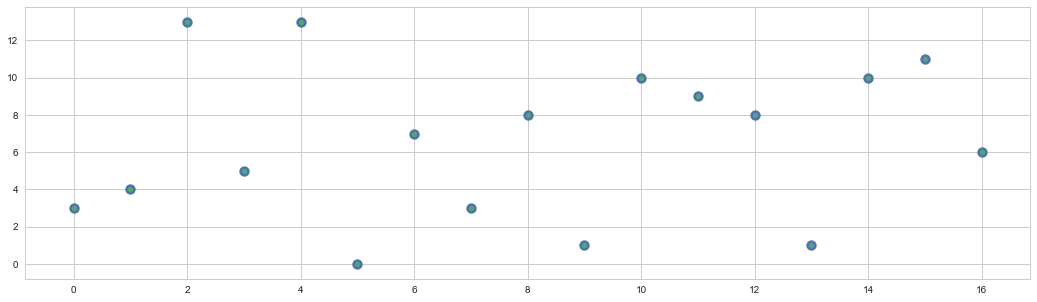

In [72]:
plt.figure(figsize=(18,5))
plt.scatter(range(17), y_test6, s=100)
plt.scatter(range(17), y_test6_mlp_predictions, s=25);

In [124]:
# MLP: Regression
def mlp_reg_model():
    model = Sequential()
    
    model.add(Dense(13, activation='relu', input_dim=13))    
    model.add(Dense(104, activation='relu'))   
    model.add(Dense(416, activation='relu'))
    
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) 
    
    return model

In [125]:
mlp_reg_model = mlp_reg_model()
mlp_reg_history = mlp_reg_model.fit(x_train4, y_train4, epochs=100, batch_size=16, verbose=0,
                                    validation_data=(x_test4, y_test4))
y_train4_mlp_predictions = mlp_reg_model.predict(x_train4)
y_test4_mlp_predictions = mlp_reg_model.predict(x_test4)

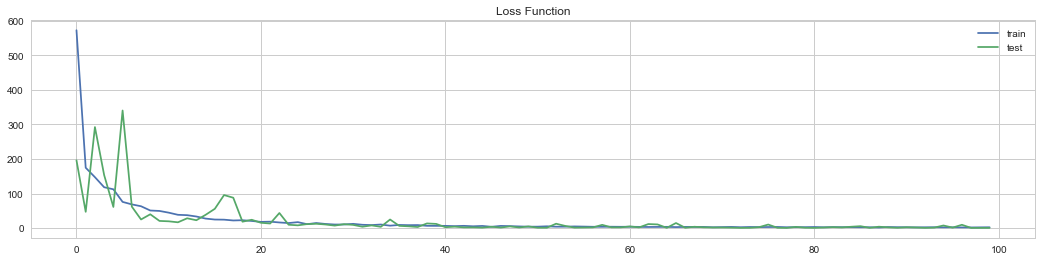

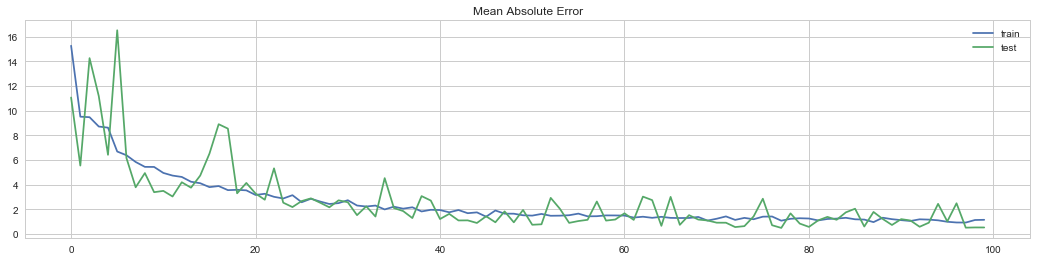

In [127]:
loss_plot(mlp_reg_history)
mae_plot(mlp_reg_history)

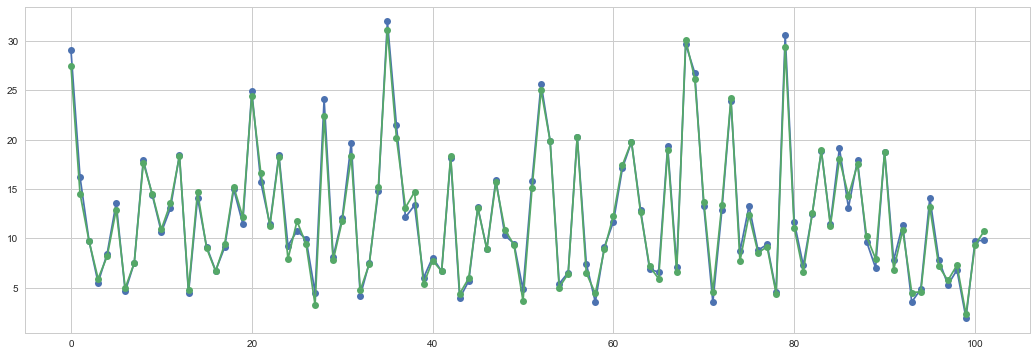

In [128]:
plt.figure(figsize=(18,6))
plt.plot(range(len(y_test4)), y_test4, '-o', label = 'real data')
plt.plot(range(len(y_test4)), y_test4_mlp_predictions, '-o', label = 'predictions');

In [129]:
mlp_reg_test_score = mlp_reg_model.evaluate(x_test4, y_test4, batch_size=102)
mlp_reg_test_score

102/102 [==============================] - 0s


[0.45933929085731506, 0.54101449251174927]

### 5.2 Convolutional Neural Network (CNN)

In [49]:
# CNN: Binary Classification
def cnn_bc_model():
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=5, padding='same', 
                     activation='relu', input_shape=(2,1)))
    model.add(Conv1D(filters=16, kernel_size=5, padding='same', activation='relu'))
    
    model.add(MaxPooling1D(pool_size=2))   
    model.add(Dropout(0.25))  

    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [50]:
cnn_bc_model = cnn_bc_model()
cnn_bc_model.fit(x_train5.reshape(800, 2, 1), y_train5.reshape(800, 1, 1), epochs=100, batch_size=8, verbose=0,
                 validation_data=(x_test5.reshape(200, 2, 1), y_test5.reshape(200, 1, 1)))
y_train5_cnn_predictions = cnn_bc_model.predict_classes(x_train5.reshape(800, 2, 1))
y_test5_cnn_predictions = cnn_bc_model.predict_classes(x_test5.reshape(200, 2, 1))

 32/200 [===>..........................] - ETA: 0s

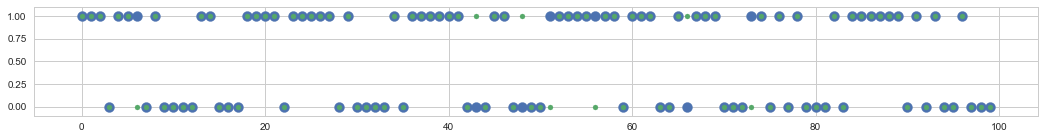

In [51]:
plt.figure(figsize=(18,2))
plt.scatter(range(100), y_test5[:100], s=100)
plt.scatter(range(100), y_test5_cnn_predictions[:100], s=25);

In [52]:
cnn_bc_test_score = cnn_bc_model.evaluate(x_test5.reshape(200, 2, 1), y_test5.reshape(200, 1, 1), batch_size=200)
cnn_bc_test_score

200/200 [==============================] - 0s


[0.20631805062294006, 0.91500002145767212]

In [70]:
# CNN: LSTM For Sequence Classification
def cnn_lstm_model():
    model = Sequential()

    model.add(Embedding(num_words, embedding_vector_length, input_length=max_length))

    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(LSTM(32))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

In [71]:
cnn_lstm_model = cnn_lstm_model()
cnn_lstm_history = cnn_lstm_model.fit(p_x_train3, y_train3, epochs=3, batch_size=128,
                                      validation_data=(p_x_test3, y_test3))

Train on 25000 samples, validate on 24819 samples
Epoch 1/3
25000/25000 [==============================] - 511s - loss: 0.4403 - acc: 0.7875 - val_loss: 0.3575 - val_acc: 0.8494

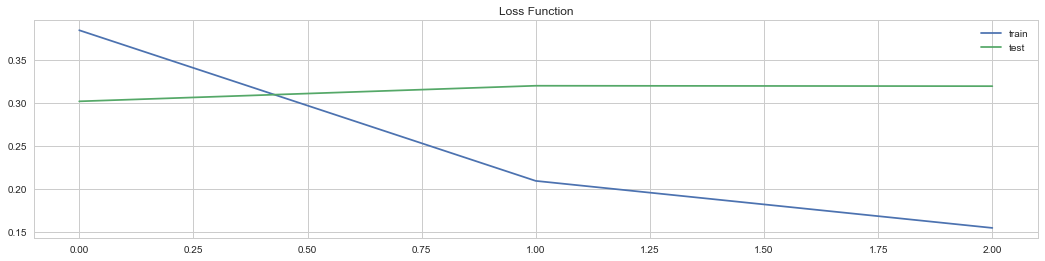

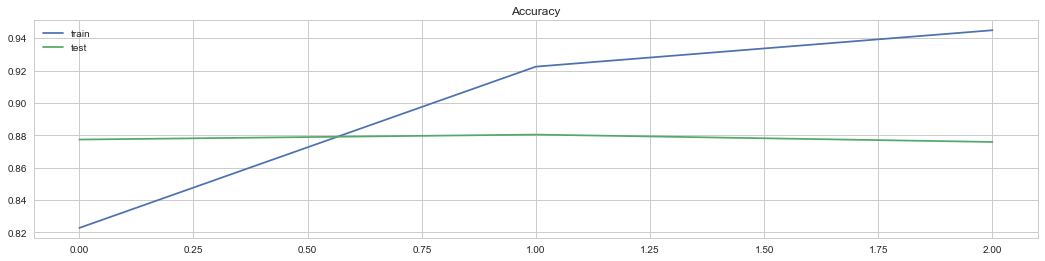

In [69]:
loss_plot(cnn_lstm_history)
acc_plot(cnn_lstm_history)

In [112]:
cnn_lstm_scores = cnn_lstm_model.evaluate(p_x_test3, y_test3, verbose=2)
print("Accuracy: %.2f%%" % (cnn_lstm_scores[1]*100))

Accuracy: 87.09%


In [87]:
# VGG-like CNN: Multi-Class Classification
def cnn_vgg_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train1.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(96, (3, 3)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5)) 

    model.add(Dense(10))
    model.add(Activation('softmax'))

#     opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [88]:
cnn_vgg_model = cnn_vgg_model()
cnn_vgg_history = cnn_vgg_model.fit(x_train1, c_y_train1, 
                                    epochs=20, batch_size=128, verbose=2,
                                    validation_data=(x_test1, c_y_test1))

y_train1_cnn_predictions = cnn_vgg_model.predict_classes(x_train1)
y_test1_cnn_predictions = cnn_vgg_model.predict_classes(x_test1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
526s - loss: 1.7451 - acc: 0.3442 - val_loss: 1.3363 - val_acc: 0.5174
Epoch 2/20
456s - loss: 1.3066 - acc: 0.5275 - val_loss: 1.1215 - val_acc: 0.5994
Epoch 3/20
443s - loss: 1.1168 - acc: 0.6063 - val_loss: 0.9687 - val_acc: 0.6632
Epoch 4/20
439s - loss: 0.9920 - acc: 0.6547 - val_loss: 0.8532 - val_acc: 0.7056
Epoch 5/20
438s - loss: 0.9082 - acc: 0.6851 - val_loss: 0.8113 - val_acc: 0.7175
Epoch 6/20
437s - loss: 0.8463 - acc: 0.7074 - val_loss: 0.7654 - val_acc: 0.7378
Epoch 7/20
436s - loss: 0.7862 - acc: 0.7245 - val_loss: 0.7274 - val_acc: 0.7515
Epoch 8/20
437s - loss: 0.7496 - acc: 0.7396 - val_loss: 0.6914 - val_acc: 0.7644
Epoch 9/20
439s - loss: 0.7077 - acc: 0.7555 - val_loss: 0.6878 - val_acc: 0.7600
Epoch 10/20
440s - loss: 0.6779 - acc: 0.7631 - val_loss: 0.6729 - val_acc: 0.7664
Epoch 11/20
459s - loss: 0.6508 - acc: 0.7739 - val_loss: 0.6916 - val_acc: 0.7663
Epoch 12/20
472s - loss: 0.6291 - acc: 0.7817 

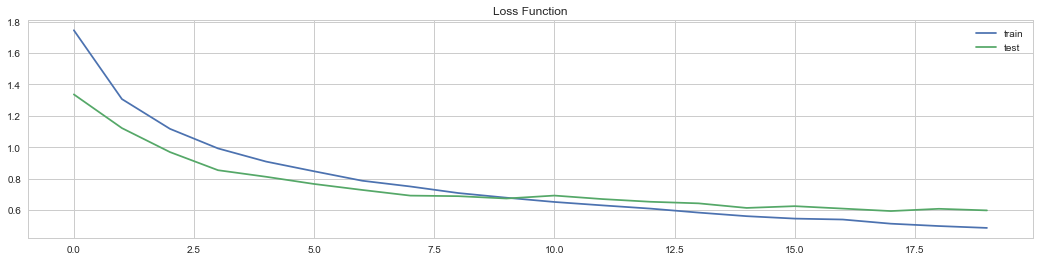

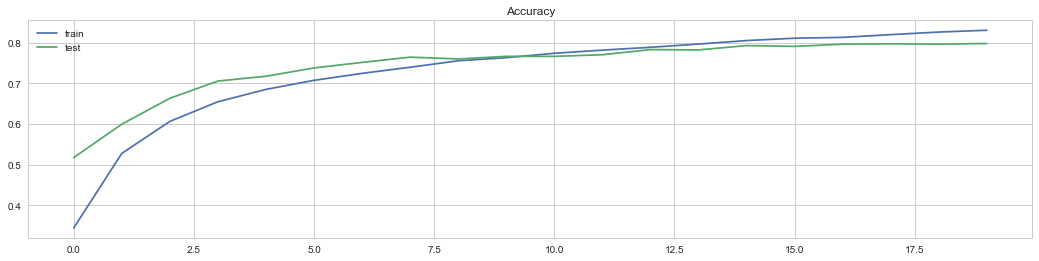

In [89]:
loss_plot(cnn_vgg_history)
acc_plot(cnn_vgg_history)

In [97]:
# steps = x_train1.shape[0]
steps, epochs = 1000, 10
data_generator = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True)
dg_cnn_vgg_history = \
cnn_vgg_model.fit_generator(data_generator.flow(x_train1, c_y_train1, batch_size=128),
                            steps_per_epoch = steps, epochs = epochs, verbose=2, 
                            validation_data = (x_test1, c_y_test1))

Epoch 1/10
1290s - loss: 0.6332 - acc: 0.7842 - val_loss: 0.5222 - val_acc: 0.8236
Epoch 2/10
1101s - loss: 0.6206 - acc: 0.7885 - val_loss: 0.5085 - val_acc: 0.8287
Epoch 3/10
1086s - loss: 0.6101 - acc: 0.7916 - val_loss: 0.5189 - val_acc: 0.8240
Epoch 4/10
1085s - loss: 0.6012 - acc: 0.7949 - val_loss: 0.5108 - val_acc: 0.8266
Epoch 5/10
1086s - loss: 0.5883 - acc: 0.7990 - val_loss: 0.5144 - val_acc: 0.8259
Epoch 6/10
1084s - loss: 0.5829 - acc: 0.8011 - val_loss: 0.4876 - val_acc: 0.8357
Epoch 7/10
1085s - loss: 0.5704 - acc: 0.8069 - val_loss: 0.4992 - val_acc: 0.8337
Epoch 8/10
1086s - loss: 0.5691 - acc: 0.8076 - val_loss: 0.5072 - val_acc: 0.8297
Epoch 9/10
1085s - loss: 0.5599 - acc: 0.8109 - val_loss: 0.4894 - val_acc: 0.8351
Epoch 10/10
1085s - loss: 0.5505 - acc: 0.8126 - val_loss: 0.4854 - val_acc: 0.8356


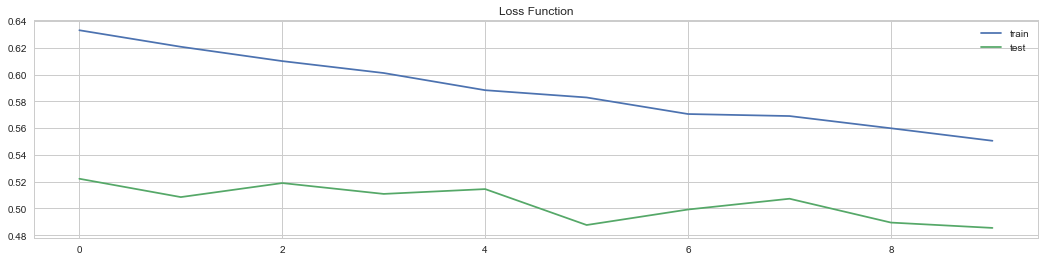

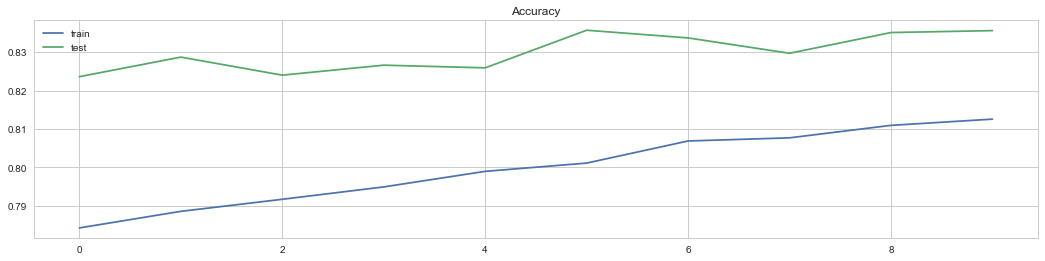

In [98]:
loss_plot(dg_cnn_vgg_history)
acc_plot(dg_cnn_vgg_history)

In [99]:
y_train1_dg_cnn_predictions = cnn_vgg_model.predict_classes(x_train1)
y_test1_dg_cnn_predictions = cnn_vgg_model.predict_classes(x_test1)

10000/10000 [==============================] - 32s     

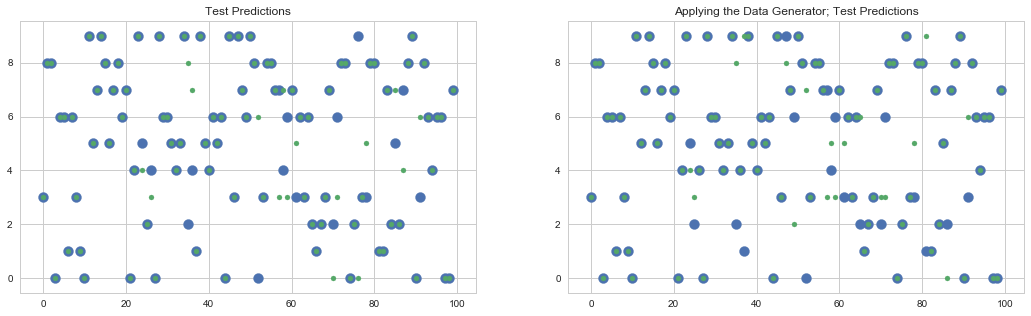

In [100]:
plt.figure(1, figsize=(18, 5))
plt.subplot(121)
plt.scatter(range(100), y_test1[:100], s=100)
plt.scatter(range(100), y_test1_cnn_predictions[:100], s=25)
plt.title("Test Predictions")
plt.subplot(122)
plt.scatter(range(100), y_test1[:100], s=100)
plt.scatter(range(100), y_test1_dg_cnn_predictions[:100], s=25)
plt.title("Applying the Data Generator; Test Predictions");

In [101]:
cnn_vgg_test_scores = cnn_vgg_model.evaluate(x_test1, c_y_test1)
print("Accuracy: %.2f%%" % (cnn_vgg_test_scores[1]*100))

10000/10000 [==============================] - 32s     

In [102]:
# cnn_vgg_model.save('cnn_vgg_model_f12.h5')
# cnn_vgg_model = load_model('cnn_vgg_model_f11.h5')

In [103]:
# VGG-like CNN: Multi-Class Classification
def cnn_vgg_model2():
    model = Sequential()
    model.add(Conv2D(48, (3, 3), padding='same', activation='relu',
                            input_shape=x_train1.shape[1:]))
    model.add(Conv2D(48, (3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(96, (3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(192, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(192, (3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_vgg_model2 = cnn_vgg_model2()
cnn_vgg_history2 = cnn_vgg_model2.fit(x_train1, c_y_train1, 
                                      validation_data = (x_test1, c_y_test1),
                                      batch_size=128, epochs=20, verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
792s - loss: 1.9141 - acc: 0.2695 - val_loss: 1.4713 - val_acc: 0.4501
Epoch 2/20
770s - loss: 1.3874 - acc: 0.4948 - val_loss: 1.1608 - val_acc: 0.5773
Epoch 3/20
706s - loss: 1.1584 - acc: 0.5873 - val_loss: 0.9965 - val_acc: 0.6426
Epoch 4/20
721s - loss: 1.0111 - acc: 0.6481 - val_loss: 0.9162 - val_acc: 0.6789
Epoch 5/20
715s - loss: 0.9060 - acc: 0.6864 - val_loss: 0.7902 - val_acc: 0.7286
Epoch 6/20
720s - loss: 0.8306 - acc: 0.7155 - val_loss: 0.7546 - val_acc: 0.7428
Epoch 7/20
754s - loss: 0.7736 - acc: 0.7367 - val_loss: 0.7035 - val_acc: 0.7614
Epoch 8/20
746s - loss: 0.7248 - acc: 0.7527 - val_loss: 0.6837 - val_acc: 0.7632
Epoch 9/20
746s - loss: 0.6799 - acc: 0.7708 - val_loss: 0.6690 - val_acc: 0.7767
Epoch 10/20
726s - loss: 0.6625 - acc: 0.7748 - val_loss: 0.6901 - val_acc: 0.7699
Epoch 11/20
721s - loss: 0.6229 - acc: 0.7890 - val_loss: 0.6225 - val_acc: 0.7920
Epoch 12/20
714s - loss: 0.5984 - acc: 0.7991 

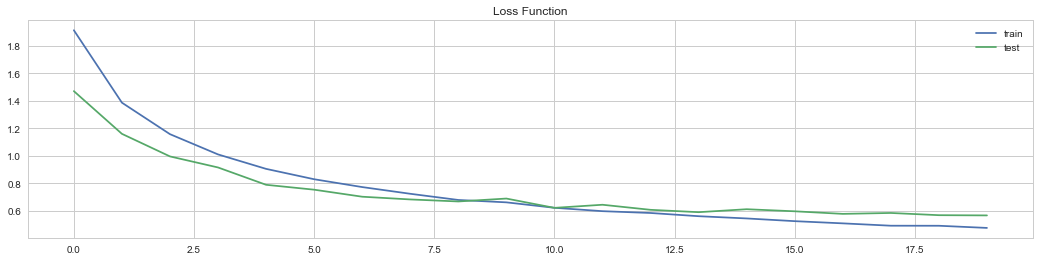

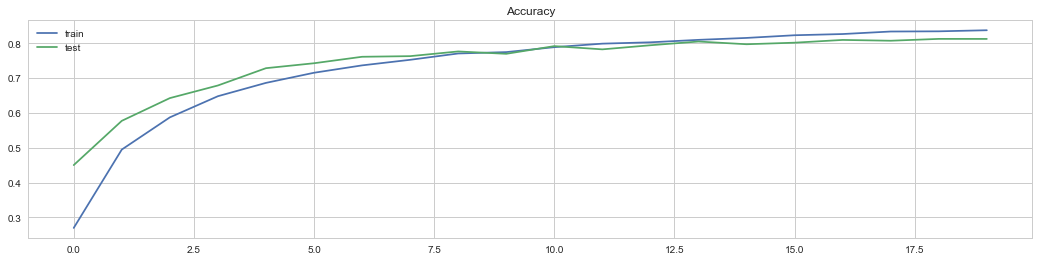

In [104]:
loss_plot(cnn_vgg_history2)
acc_plot(cnn_vgg_history2)

In [105]:
y_train1_cnn_vgg2 = cnn_vgg_model2.predict_classes(x_train1)
y_test1_cnn_vgg2 = cnn_vgg_model2.predict_classes(x_test1)

10000/10000 [==============================] - 51s     

In [126]:
steps, epochs = 500, 10
data_generator = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True)
dg_cnn_vgg_history2 = \
cnn_vgg_model2.fit_generator(data_generator.flow(x_train1, c_y_train1, batch_size=128),
                             steps_per_epoch = steps, epochs = epochs, verbose=2, 
                             validation_data = (x_test1, c_y_test1))

Epoch 1/10
961s - loss: 0.7095 - acc: 0.7689 - val_loss: 0.5946 - val_acc: 0.7971
Epoch 2/10
893s - loss: 0.6823 - acc: 0.7756 - val_loss: 0.5879 - val_acc: 0.8097
Epoch 3/10
893s - loss: 0.6655 - acc: 0.7802 - val_loss: 0.5485 - val_acc: 0.8210
Epoch 4/10
893s - loss: 0.6609 - acc: 0.7823 - val_loss: 0.6213 - val_acc: 0.7981
Epoch 5/10
894s - loss: 0.6460 - acc: 0.7878 - val_loss: 0.5396 - val_acc: 0.8224
Epoch 6/10
893s - loss: 0.6432 - acc: 0.7900 - val_loss: 0.5572 - val_acc: 0.8105
Epoch 7/10
905s - loss: 0.6309 - acc: 0.7902 - val_loss: 0.5586 - val_acc: 0.8127
Epoch 8/10
892s - loss: 0.6178 - acc: 0.7971 - val_loss: 0.5483 - val_acc: 0.8132
Epoch 9/10
894s - loss: 0.6237 - acc: 0.7948 - val_loss: 0.5371 - val_acc: 0.8172
Epoch 10/10
892s - loss: 0.6124 - acc: 0.7968 - val_loss: 0.5033 - val_acc: 0.8343


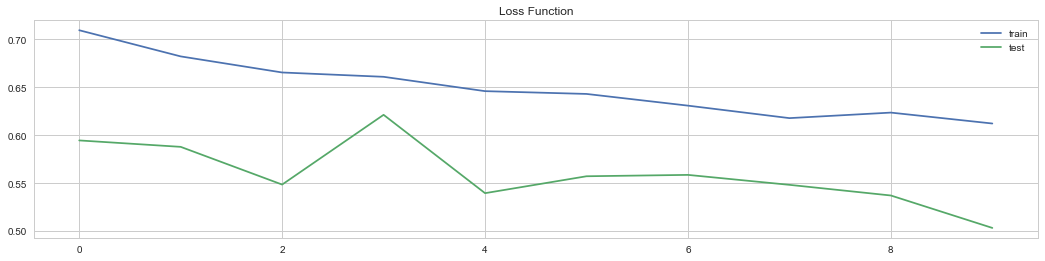

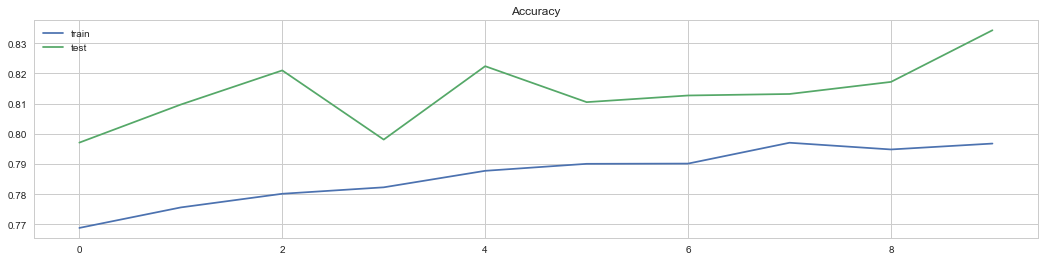

In [127]:
loss_plot(dg_cnn_vgg_history2)
acc_plot(dg_cnn_vgg_history2)

In [128]:
y_train1_dg_cnn_vgg2 = cnn_vgg_model2.predict_classes(x_train1)
y_test1_dg_cnn_vgg2 = cnn_vgg_model2.predict_classes(x_test1)

10000/10000 [==============================] - 51s     

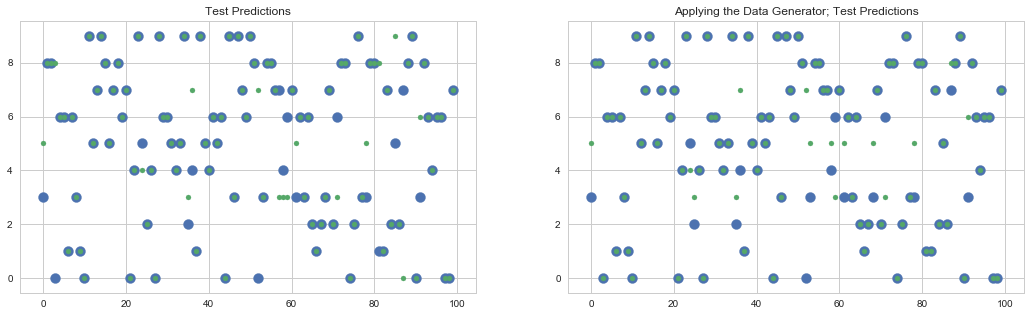

In [129]:
plt.figure(1, figsize=(18, 5))
plt.subplot(121)
plt.scatter(range(100), y_test1[:100], s=100)
plt.scatter(range(100), y_test1_cnn_vgg2[:100], s=25)
plt.title("Test Predictions")
plt.subplot(122)
plt.scatter(range(100), y_test1[:100], s=100)
plt.scatter(range(100), y_test1_dg_cnn_vgg2[:100], s=25)
plt.title("Applying the Data Generator; Test Predictions");

In [130]:
cnn_vgg_test_scores2 = cnn_vgg_model2.evaluate(x_test1, c_y_test1)
print("Accuracy: %.2f%%" % (cnn_vgg_test_scores2[1]*100))

10000/10000 [==============================] - 50s     

In [131]:
# cnn_vgg_model2.save('cnn_vgg_model2_f11.h5')
# cnn_vgg_model2 = load_model('cnn_vgg_model2_f11.h5')

In [329]:
# CNN: Regression
def cnn_reg_model():
    model = Sequential()
    
#    model.add(BatchNormalization(input_shape=(13,1)))
        
    model.add(Conv1D(13, 5, padding='valid', activation='relu', input_shape=(13,1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(104, 3, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    
    model.add(Flatten())

    model.add(Dense(832, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(1, kernel_initializer='normal'))
    
#    opt = keras.optimizers.rmsprop(decay=1e-6)
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model    

In [330]:
cnn_reg_model = cnn_reg_model()
cnn_reg_history = cnn_reg_model.fit(x_train4.reshape(404, 13, 1), y_train4, epochs=1600, batch_size=13, verbose=0,
                                    validation_data=(x_test4.reshape(102, 13, 1), y_test4))
y_train4_cnn_predictions = cnn_reg_model.predict(x_train4.reshape(404, 13, 1))
y_test4_cnn_predictions = cnn_reg_model.predict(x_test4.reshape(102, 13, 1))

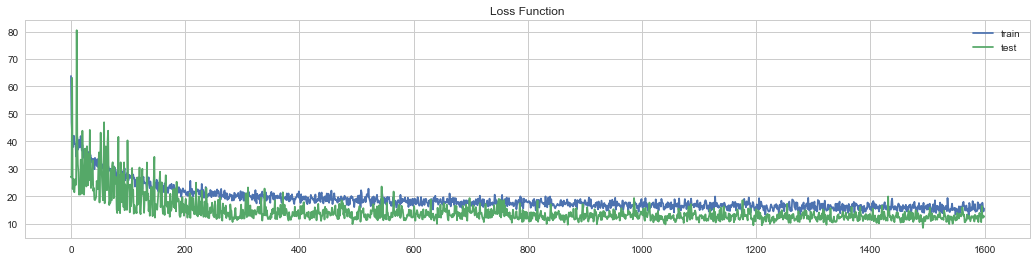

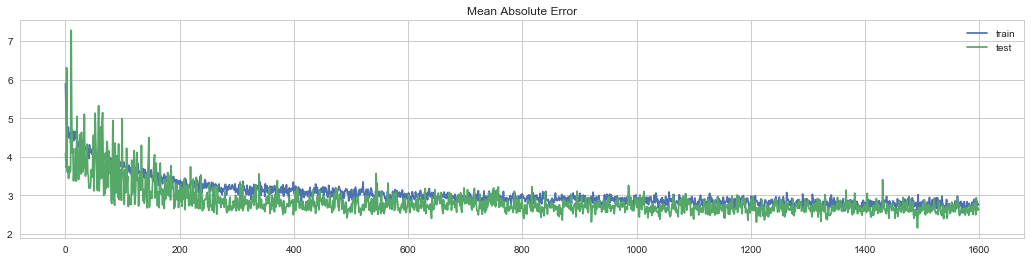

In [331]:
loss_plot(cnn_reg_history)
mae_plot(cnn_reg_history)

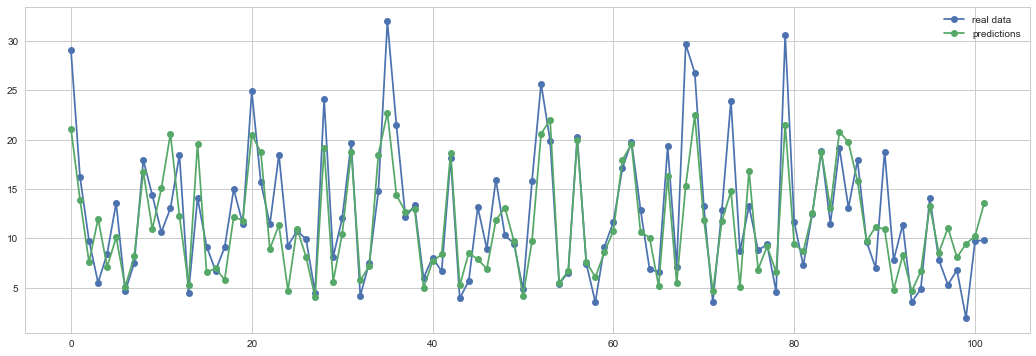

In [324]:
# epochs=400
plt.figure(figsize=(18,6))
plt.plot(range(len(y_test4)), y_test4, '-o', label = 'real data')
plt.plot(range(len(y_test4)), y_test4_cnn_predictions, '-o', label = 'predictions')
plt.legend();

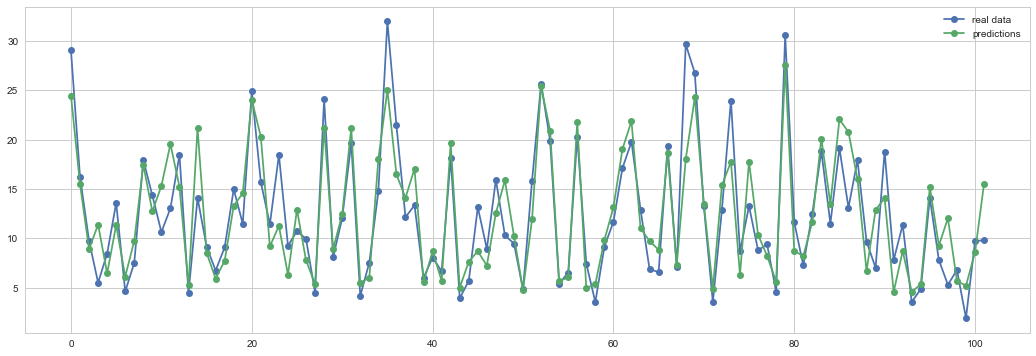

In [328]:
# epochs=800
plt.figure(figsize=(18,6))
plt.plot(range(len(y_test4)), y_test4, '-o', label = 'real data')
plt.plot(range(len(y_test4)), y_test4_cnn_predictions, '-o', label = 'predictions')
plt.legend();

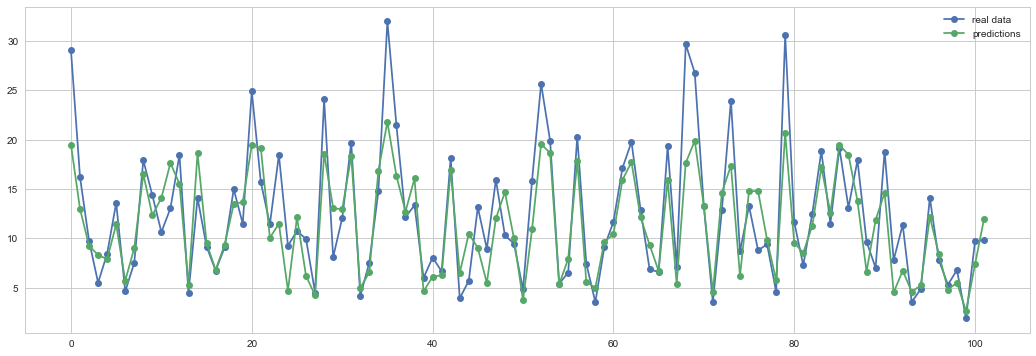

In [332]:
# epochs=1600
plt.figure(figsize=(18,6))
plt.plot(range(len(y_test4)), y_test4, '-o', label = 'real data')
plt.plot(range(len(y_test4)), y_test4_cnn_predictions, '-o', label = 'predictions')
plt.legend();

### 5.3 Recurrent Neural Network (RNN)

In [182]:
# RNN: Binary Classification
def rnn_bc_model():
    model = Sequential()

    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(1, 2)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])     
    
    return model 

In [183]:
rnn_bc_model = rnn_bc_model()
rnn_bc_history = rnn_bc_model.fit(x_train5.reshape(x_train5.shape[0], 1, x_train5.shape[1]), 
                                  y_train5.reshape(y_train5.shape[0], 1), 
                                  epochs=20, batch_size=32, verbose=2,
                                  validation_data=(x_test5.reshape(x_test5.shape[0], 1, x_test5.shape[1]), 
                                                   y_test5.reshape(y_test5.shape[0], 1)))

y_train5_rnn_predictions = rnn_bc_model.predict_classes(x_train5.reshape(x_train5.shape[0], 1, x_train5.shape[1]))
y_test5_rnn_predictions = rnn_bc_model.predict_classes(x_test5.reshape(x_test5.shape[0], 1, x_test5.shape[1]))

Train on 800 samples, validate on 200 samples
Epoch 1/20
11s - loss: 0.6834 - acc: 0.6088 - val_loss: 0.6673 - val_acc: 0.8150
Epoch 2/20
0s - loss: 0.6551 - acc: 0.8000 - val_loss: 0.6397 - val_acc: 0.8700
Epoch 3/20
0s - loss: 0.6261 - acc: 0.8163 - val_loss: 0.6103 - val_acc: 0.8700
Epoch 4/20
0s - loss: 0.5958 - acc: 0.8212 - val_loss: 0.5792 - val_acc: 0.8500
Epoch 5/20
0s - loss: 0.5737 - acc: 0.8025 - val_loss: 0.5488 - val_acc: 0.8400
Epoch 6/20
0s - loss: 0.5333 - acc: 0.8362 - val_loss: 0.5148 - val_acc: 0.8550
Epoch 7/20
0s - loss: 0.5098 - acc: 0.8325 - val_loss: 0.4837 - val_acc: 0.8500
Epoch 8/20
0s - loss: 0.4862 - acc: 0.8625 - val_loss: 0.4541 - val_acc: 0.8550
Epoch 9/20
0s - loss: 0.4539 - acc: 0.8513 - val_loss: 0.4272 - val_acc: 0.8550
Epoch 10/20
0s - loss: 0.4368 - acc: 0.8612 - val_loss: 0.4042 - val_acc: 0.8550
Epoch 11/20
0s - loss: 0.4074 - acc: 0.8575 - val_loss: 0.3842 - val_acc: 0.8600
Epoch 12/20
0s - loss: 0.4017 - acc: 0.8638 - val_loss: 0.3677 - val_ac

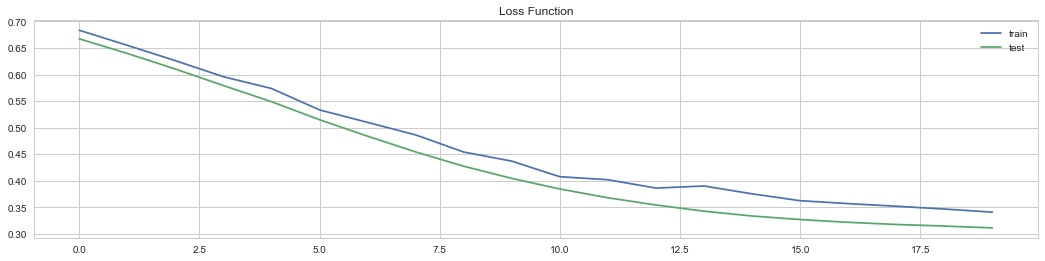

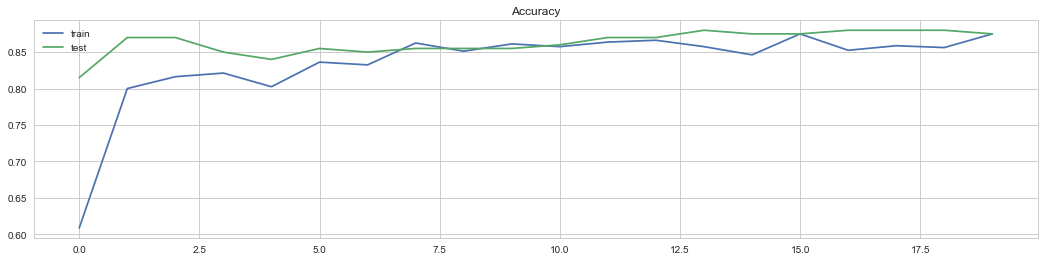

In [184]:
loss_plot(rnn_bc_history)
acc_plot(rnn_bc_history)

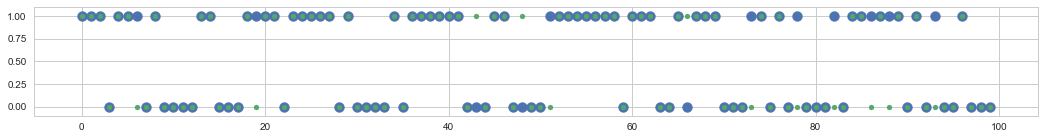

In [185]:
plt.figure(figsize=(18,2))
plt.scatter(range(100), y_test5[:100], s=100)
plt.scatter(range(100), y_test5_rnn_predictions[:100], s=25);

In [120]:
# RNN: Multi-Class Classification
def rnn_mc_model():
    model = Sequential()

    model.add(LSTM(112, return_sequences=True, input_shape=(1,784)))
    
    model.add(LSTM(112, return_sequences=True)) 
    model.add(LSTM(112))  
    
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])    
    return model 

In [121]:
rnn_mc_model = rnn_mc_model()
rnn_mc_history = rnn_mc_model.fit(x_train2.reshape(x_train2.shape[0], 1, x_train2.shape[1]), y_train2, 
                                  epochs=10, batch_size=128, verbose=2,
                                  validation_data=(x_test2.reshape(x_test2.shape[0], 1, x_test2.shape[1]), y_test2))
y_train2_rnn_predictions = rnn_mc_model.predict_classes(x_train2.reshape(x_train2.shape[0], 1, x_train2.shape[1]))
y_test2_rnn_predictions = rnn_mc_model.predict_classes(x_test2.reshape(x_test2.shape[0], 1, x_test2.shape[1]))

Train on 55000 samples, validate on 10000 samples
Epoch 1/10
34s - loss: 0.3061 - acc: 0.9101 - val_loss: 0.1241 - val_acc: 0.9635
Epoch 2/10
24s - loss: 0.1013 - acc: 0.9693 - val_loss: 0.0958 - val_acc: 0.9700
Epoch 3/10
24s - loss: 0.0660 - acc: 0.9802 - val_loss: 0.0915 - val_acc: 0.9721
Epoch 4/10
24s - loss: 0.0468 - acc: 0.9855 - val_loss: 0.0862 - val_acc: 0.9742
Epoch 5/10
24s - loss: 0.0328 - acc: 0.9892 - val_loss: 0.0920 - val_acc: 0.9733
Epoch 6/10
24s - loss: 0.0297 - acc: 0.9905 - val_loss: 0.0895 - val_acc: 0.9766
Epoch 7/10
24s - loss: 0.0228 - acc: 0.9924 - val_loss: 0.0794 - val_acc: 0.9767
Epoch 8/10
24s - loss: 0.0193 - acc: 0.9935 - val_loss: 0.0786 - val_acc: 0.9797
Epoch 9/10
24s - loss: 0.0153 - acc: 0.9951 - val_loss: 0.0992 - val_acc: 0.9745
Epoch 10/10
24s - loss: 0.0161 - acc: 0.9944 - val_loss: 0.0910 - val_acc: 0.9773
 9888/10000 [============================>.] - ETA: 0s   

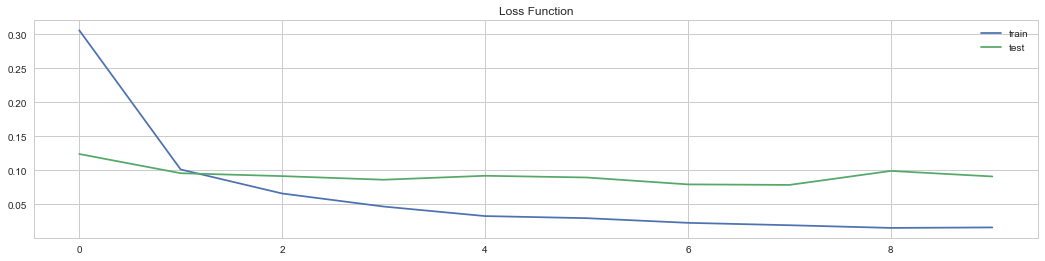

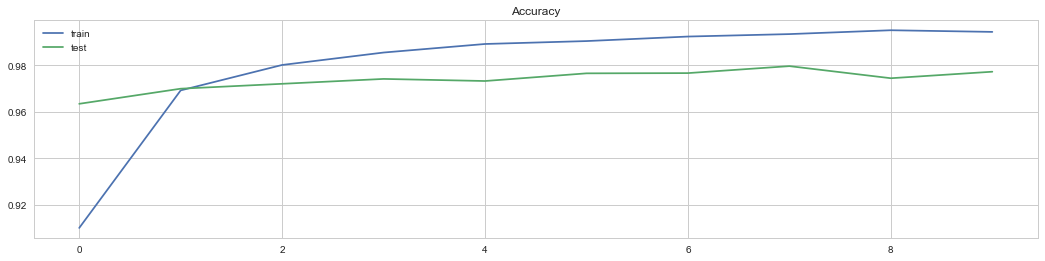

In [124]:
loss_plot(rnn_mc_history)
acc_plot(rnn_mc_history)

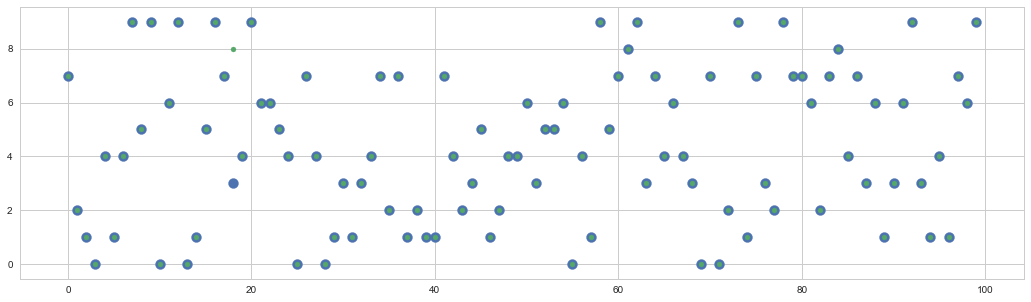

In [125]:
plt.figure(figsize=(18, 5))
plt.scatter(range(100), y_test2_class[:100], s=100)
plt.scatter(range(100), y_test2_rnn_predictions[:100], s=25);

In [201]:
# RNN: Regression
def rnn_reg_model():
    model = Sequential()
    
    model.add(LSTM(52, return_sequences=True, input_shape=(1, 13)))
    model.add(LSTM(208, return_sequences=False))   
    
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) 
    
    return model 

In [202]:
rnn_reg_model = rnn_reg_model()

rnn_reg_history = rnn_reg_model.fit(x_train4.reshape(x_train4.shape[0], 1, x_train4.shape[1]), y_train4, 
                                    validation_data=(x_test4.reshape(x_test4.shape[0], 1, x_test4.shape[1]),y_test4), 
                                    epochs=800, verbose=0)

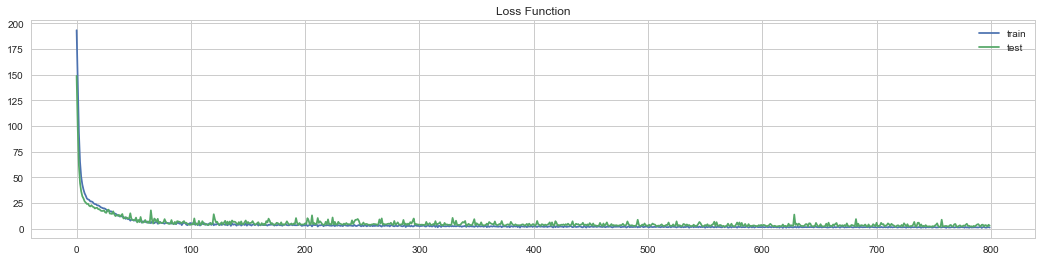

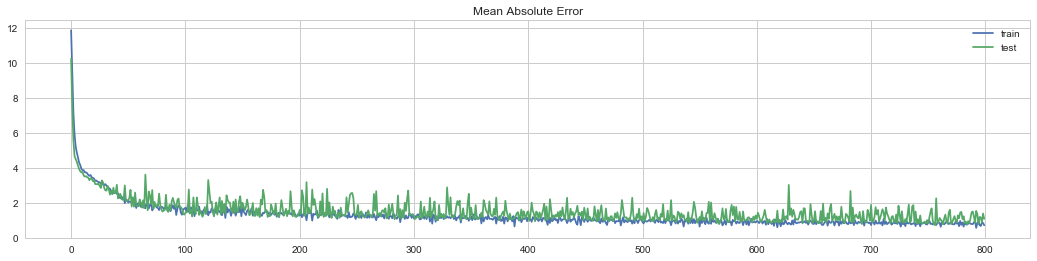

In [203]:
loss_plot(rnn_reg_history)
mae_plot(rnn_reg_history)

In [199]:
y_train4_rnn_predictions = rnn_reg_model.predict(x_train4.reshape(x_train4.shape[0], 1, x_train4.shape[1]))
y_test4_rnn_predictions = rnn_reg_model.predict(x_test4.reshape(102, 1, 13))

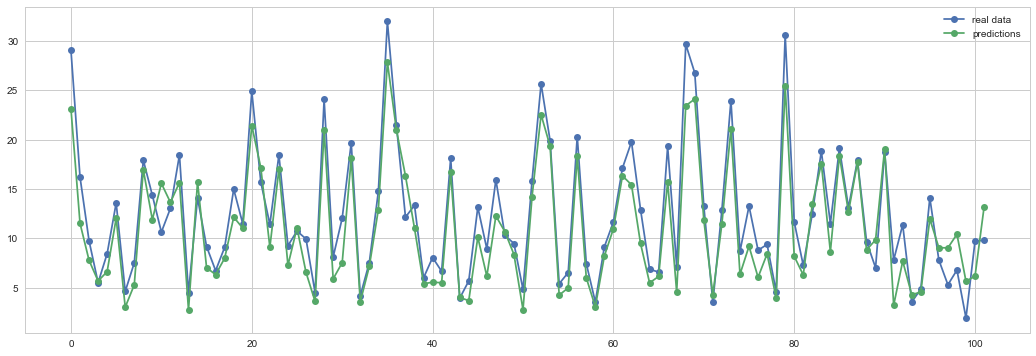

In [181]:
# epochs=50
plt.figure(figsize=(18,6))
plt.plot(range(len(y_test4)), y_test4, '-o', label = 'real data')
plt.plot(range(len(y_test4)), y_test4_rnn_predictions, '-o', label = 'predictions')
plt.legend();

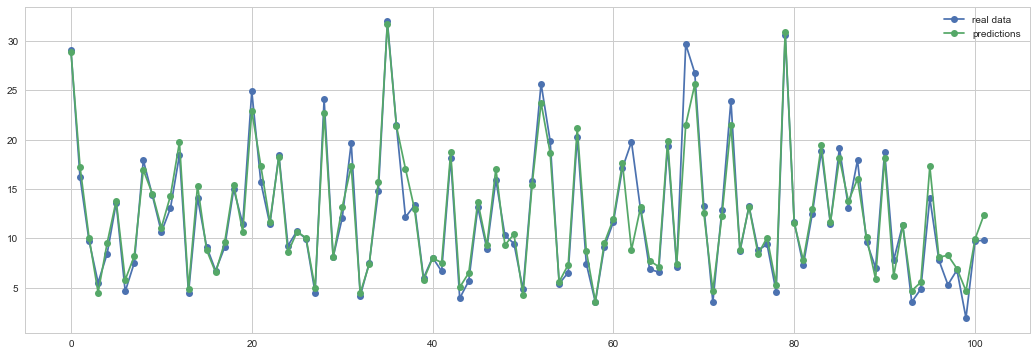

In [200]:
# epochs=200
plt.figure(figsize=(18,6))
plt.plot(range(len(y_test4)), y_test4, '-o', label = 'real data')
plt.plot(range(len(y_test4)), y_test4_rnn_predictions, '-o', label = 'predictions')
plt.legend();

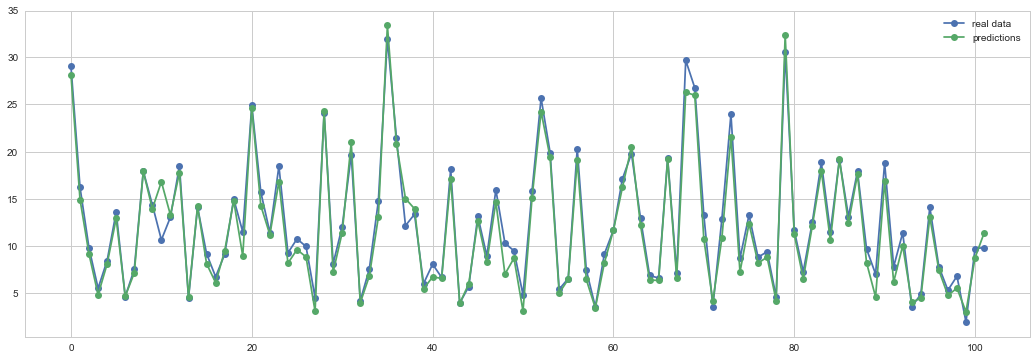

In [195]:
# epochs=800
plt.figure(figsize=(18,6))
plt.plot(range(len(y_test4)), y_test4, '-o', label = 'real data')
plt.plot(range(len(y_test4)), y_test4_rnn_predictions, '-o', label = 'predictions')
plt.legend();

## 6. Applications

In [74]:
resnet50_model = ResNet50(weights='imagenet')
# resnet50_model_json = resnet50_model.to_json()

# with open("resnet50.json", "w") as json_file:
#     json_file.write(resnet50_model_json)

# json_file = open('resnet50.json', 'r')
# resnet50_model_json = json_file.read()
# json_file.close()

# resnet50_model = model_from_json(resnet50_model_json)

Predicted: [('n02123394', 'Persian_cat', 0.5807485), ('n02120079', 'Arctic_fox', 0.087616719), ('n02120505', 'grey_fox', 0.044340547), ('n02123045', 'tabby', 0.041976523), ('n02119022', 'red_fox', 0.032001797)]


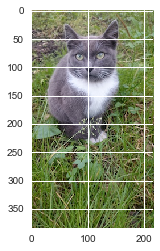

In [85]:
# Classify imagenet_class_index.json classes with ResNet50
cat_image = keras_image.load_img('cat.png', target_size=(224, 224))
CLASS_INDEX = None

x = keras_image.img_to_array(cat_image)
x = np.expand_dims(x, axis=0)
x = resnet50_preprocess_input(x)

cat_predictions = resnet50_model.predict(x)
print('Predicted:', decode_predictions2(cat_predictions, 'imagenet_class_index.json')[0])

cv_cat_image = cv2.imread('cat.png')
rgb_cat_image = cv2.cvtColor(cv_cat_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_cat_image);

In [91]:
# Extract image features with VGG16

# https://github.com/fchollet/deep-learning-models/releases/download/v0.1/
# vgg16_weights_tf_dim_ordering_tf_kernels.h5
# vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

vgg16_model = VGG16(weights='imagenet', include_top=False)
cat_image = keras_image.load_img('cat.png', target_size=(224, 224))

y = keras_image.img_to_array(cat_image)
y = np.expand_dims(y, axis=0)
y = vgg16_preprocess_input(y)

cat_features16 = vgg16_model.predict(y)
np.argmax(cat_features16)

5406

In [58]:
# Extract image features with VGG19

# https://github.com/fchollet/deep-learning-models/releases/download/v0.1/
# vgg19_weights_tf_dim_ordering_tf_kernels.h5
# vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5

vgg19_model = VGG19(weights='imagenet')
cat_image = keras_image.load_img('cat.png', target_size=(224, 224))

z = keras_image.img_to_array(cat_image)
z = np.expand_dims(z, axis=0)
z = vgg19_preprocess_input(z)

cat_features19 = vgg19_model.predict(z)
np.argmax(cat_features19)

281

In [77]:
# InceptionV3 for a new dataset

# https://github.com/fchollet/deep-learning-models/releases/download/v0.1/
# inception_v3_weights_tf_dim_ordering_tf_kernels.h5
# inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

iv3_base_model = InceptionV3(weights='imagenet', include_top=False)
x = iv3_base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)

y = Dense(10, activation='softmax')(x)

iv3_model = Model(inputs=iv3_base_model.input, outputs=y)

In [78]:
# Freeze InceptionV3 convolutional layers
for layer in iv3_base_model.layers:
    layer.trainable = False
    
iv3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])    

In [79]:
steps, epochs = 189, 10
data_generator = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [80]:
iv3_history = iv3_model.fit_generator(data_generator.flow(x_train7, c_y_train7, batch_size=64),
                                      steps_per_epoch = steps, epochs = epochs, verbose=2, 
                                      validation_data = (x_test7, c_y_test7))

Epoch 1/10
1074s - loss: 0.5377 - acc: 0.8471 - val_loss: 1.5102 - val_acc: 0.5714
Epoch 2/10
1057s - loss: 0.1871 - acc: 0.9418 - val_loss: 0.9527 - val_acc: 0.6667
Epoch 3/10
1059s - loss: 0.1453 - acc: 0.9551 - val_loss: 1.0061 - val_acc: 0.6667
Epoch 4/10
1051s - loss: 0.1157 - acc: 0.9640 - val_loss: 1.0380 - val_acc: 0.7619
Epoch 5/10
1030s - loss: 0.1033 - acc: 0.9677 - val_loss: 1.0999 - val_acc: 0.5238
Epoch 6/10
961s - loss: 0.1011 - acc: 0.9680 - val_loss: 0.8548 - val_acc: 0.6667
Epoch 7/10
976s - loss: 0.0891 - acc: 0.9730 - val_loss: 0.9401 - val_acc: 0.6667
Epoch 8/10
969s - loss: 0.0836 - acc: 0.9739 - val_loss: 0.9220 - val_acc: 0.8095
Epoch 9/10
971s - loss: 0.0639 - acc: 0.9793 - val_loss: 0.8857 - val_acc: 0.7143
Epoch 10/10
963s - loss: 0.0563 - acc: 0.9819 - val_loss: 0.9472 - val_acc: 0.7143


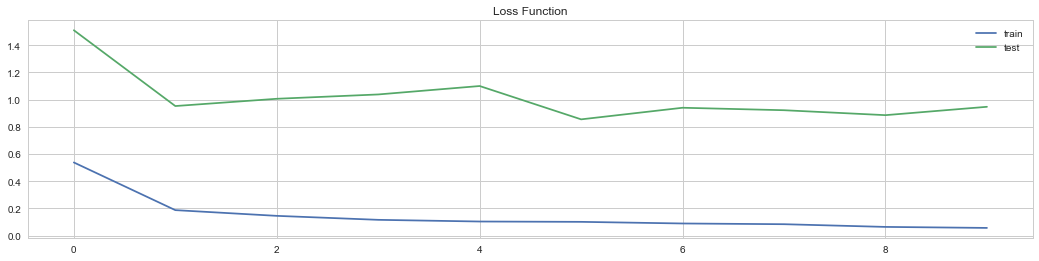

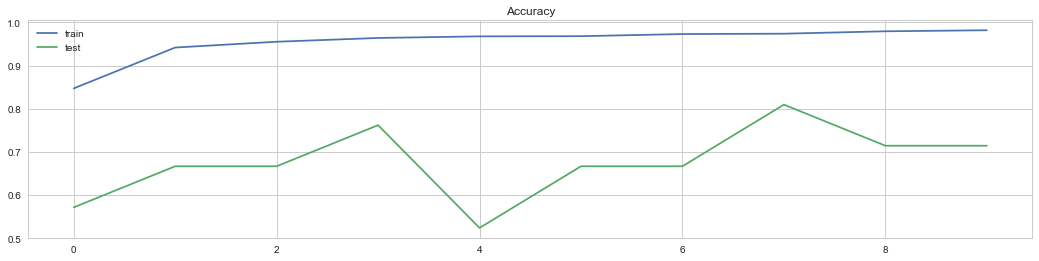

In [84]:
loss_plot(iv3_history)
acc_plot(iv3_history)

In [89]:
for i, layer in enumerate(iv3_base_model.layers[173:]):
    print(i, layer.name)

0 batch_normalization_428
1 batch_normalization_433
2 activation_428
3 activation_433
4 conv2d_429
5 conv2d_434
6 batch_normalization_429
7 batch_normalization_434
8 activation_429
9 activation_434
10 average_pooling2d_42
11 conv2d_427
12 conv2d_430
13 conv2d_435
14 conv2d_436
15 batch_normalization_427
16 batch_normalization_430
17 batch_normalization_435
18 batch_normalization_436
19 activation_427
20 activation_430
21 activation_435
22 activation_436
23 mixed6
24 conv2d_441
25 batch_normalization_441
26 activation_441
27 conv2d_442
28 batch_normalization_442
29 activation_442
30 conv2d_438
31 conv2d_443
32 batch_normalization_438
33 batch_normalization_443
34 activation_438
35 activation_443
36 conv2d_439
37 conv2d_444
38 batch_normalization_439
39 batch_normalization_444
40 activation_439
41 activation_444
42 average_pooling2d_43
43 conv2d_437
44 conv2d_440
45 conv2d_445
46 conv2d_446
47 batch_normalization_437
48 batch_normalization_440
49 batch_normalization_445
50 batch_normaliz

In [90]:
for layer in iv3_model.layers[:173]:
    layer.trainable = False
for layer in iv3_model.layers[173:]:
    layer.trainable = True
    
iv3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])        

In [91]:
steps, epochs = 189, 5
iv3_history2 = iv3_model.fit_generator(data_generator.flow(x_train7, c_y_train7, batch_size=64),
                                       steps_per_epoch = steps, epochs = epochs, verbose=2, 
                                       validation_data = (x_test7, c_y_test7))

Epoch 1/5
1768s - loss: 0.2137 - acc: 0.9710 - val_loss: 0.4653 - val_acc: 0.9524
Epoch 2/5
1669s - loss: 0.1295 - acc: 0.9910 - val_loss: 0.4274 - val_acc: 0.9524
Epoch 3/5
1760s - loss: 0.2529 - acc: 0.9829 - val_loss: 0.3532 - val_acc: 0.9524
Epoch 4/5
1736s - loss: 0.2296 - acc: 0.9845 - val_loss: 0.3842 - val_acc: 0.8571
Epoch 5/5
1740s - loss: 0.1518 - acc: 0.9869 - val_loss: 0.9682 - val_acc: 0.8571


In [94]:
# Xception 

# https://github.com/fchollet/deep-learning-models/releases/download/v0.1/
# xception_weights_tf_dim_ordering_tf_kernels.h5
# xception_weights_tf_dim_ordering_tf_kernels_notop.h5

xce_model = Xception(include_top=True, weights='imagenet')